In [ ]:
!pip uninstall mediapipe -y
!pip install mediapipe==0.10.14
!pip install gtts

Found existing installation: mediapipe 0.10.14
Uninstalling mediapipe-0.10.14:
  Successfully uninstalled mediapipe-0.10.14
  Using cached mediapipe-0.10.14-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.7 kB)
Using cached mediapipe-0.10.14-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (35.7 MB)


In [ ]:
import cv2
import numpy as np
import os
import mediapipe as mp

# Bypassing mp.solutions entirely
from mediapipe.python.solutions.holistic import Holistic
from mediapipe.python.solutions.drawing_utils import draw_landmarks

# Test initialization
try:
    holistic_model = Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    print("✅ ABSOLUTE SUCCESS: The model is initialized.")
except Exception as e:
    print(f"❌ Error: {e}")

✅ ABSOLUTE SUCCESS: The model is initialized.


In [ ]:
def extract_keypoints(results):
    # Pose: 33 landmarks * 4 (x, y, z, visibility) = 132
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    # Face: 468 landmarks * 3 (x, y, z) = 1404
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    # Left Hand: 21 landmarks * 3 (x, y, z) = 63
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    # Right Hand: 21 landmarks * 3 (x, y, z) = 63
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

    return np.concatenate([pose, face, lh, rh]) # Total: 1662 features

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input

def build_sas_model(num_classes):
    model = Sequential([
        Input(shape=(30, 1662)), # 30 frames per video, 1662 features per frame
        Bidirectional(LSTM(64, return_sequences=True, activation='relu')),
        Dropout(0.2),
        Bidirectional(LSTM(128, return_sequences=False, activation='relu')),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax') # Predicts the Malayalam word
    ])
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from gtts import gTTS
import IPython.display as ipd

def play_malayalam_audio(text):
    # 'ml' is the language code for Malayalam
    tts = gTTS(text=text, lang='ml')
    tts.save("prediction.mp3")
    return ipd.Audio("prediction.mp3", autoplay=True)

# Example: play_malayalam_audio("നമസ്കാരം")

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

# Set your paths
DATA_PATH = '/content/drive/MyDrive/Malayalam/MALAYALAM'
# Get the names of your signs (folder names)
actions = np.array([folder for folder in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, folder))])

# Define parameters
no_sequences = 30  # Videos per sign
sequence_length = 30 # Frames per video

print(f"Detected Signs: {actions}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Detected Signs: ['Dynamic' 'Static']


In [ ]:
# Create the base feature directory
import os
import numpy as np

# Ensure the features folder exists
os.makedirs('/content/features', exist_ok=True)

# Let's check what's actually in your MSLCD_Data folder

print("Folders found in Drive:", os.listdir(DATA_PATH))

# Update actions to match EXACT folder names
actions = np.array([f for f in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, f))])
print("Actions to be processed:", actions)

Folders found in Drive: ['README for Malayalam Sign Language Dataset.txt', 'Dataset Description.docx', 'annotations.csv', 'Dynamic', 'Static']
Actions to be processed: ['Dynamic' 'Static']


In [ ]:
def extract_and_save():
    for action in actions:
        save_dir = f'/content/features/{action}'
        os.makedirs(save_dir, exist_ok=True)

        action_path = os.path.join(DATA_PATH, action)
        videos = [v for v in os.listdir(action_path) if v.endswith(('.mp4', '.avi', '.MOV'))]

        print(f"Processing {len(videos)} videos for sign: {action}...")

        for idx, video in enumerate(videos[:no_sequences]):
            video_path = os.path.join(action_path, video)
            cap = cv2.VideoCapture(video_path)
            window = []

            # Use the holistic_model we successfully initialized earlier
            for frame_num in range(sequence_length):
                ret, frame = cap.read()
                if not ret:
                    window.append(np.zeros(1662)) # Constant for 543 landmarks
                    continue

                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = holistic_model.process(image)
                window.append(extract_keypoints(results))

            cap.release()
            np.save(os.path.join(save_dir, f'{idx}.npy'), window)

    print("✅ Extraction Complete! Training can now start.")

extract_and_save()

Processing 0 videos for sign: Dynamic...
Processing 0 videos for sign: Static...
✅ Extraction Complete! Training can now start.


In [ ]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical

X, y = [], []

# Ensure 'actions' and 'label_map' are defined from a previous cell,
# or define them here if this cell is meant to be standalone.
# Based on your notebook state, 'actions' is ['Dynamic', 'Static'] and
# 'label_map' was defined in a deleted cell or in 3DqklE7s8Pqj.
# Also, the previous extraction step reported 0 videos processed.

# Placeholder for 'actions' and 'label_map' for demonstrative purposes,
# assuming they would be populated if data extraction was successful.
# In your current state, this part will likely result in empty X and y.

# The actions variable from the kernel state is ['Dynamic', 'Static']
# For this cell to work, you would need a valid `label_map` like this:
# label_map = {label: num for num, label in enumerate(actions)}
# Based on the successful run of j-_U2W2eEeuj, the correct actions are
# derived from /content/features after images are processed.

# Re-loading actions and creating a label_map that reflects actual data
FEATURES_PATH = '/content/features/'
if os.path.exists(FEATURES_PATH):
    current_actions = np.array([s for s in os.listdir(FEATURES_PATH) if os.path.isdir(os.path.join(FEATURES_PATH, s))])
    if len(current_actions) > 0:
        label_map = {label:num for num, label in enumerate(current_actions)}
    else:
        print("Warning: No valid action folders found in /content/features/")
        label_map = {}
else:
    print("Error: /content/features/ directory not found.")
    label_map = {}
    current_actions = np.array([])


# Use 'current_actions' here for loading data based on available features
for action in current_actions:
    feature_path = f'/content/features/{action}'
    if os.path.exists(feature_path):
        for filename in os.listdir(feature_path):
            try:
                res = np.load(os.path.join(feature_path, filename))
                X.append(res)
                if action in label_map:
                    y.append(label_map[action])
                else:
                    print(f"Warning: '{action}' not in label_map. Skipping.")
            except Exception as e:
                print(f"Error loading {filename} for action {action}: {e}")


X = np.array(X)

if len(y) > 0 and len(label_map) > 0: # Ensure y is not empty and label_map is valid
    y = to_categorical(y, num_classes=len(label_map)).astype(int)
    print(f"Successfully loaded {len(X)} samples with {len(label_map)} classes.")
else:
    print("Warning: No data to process for y, or label_map is empty.")

# The variables X_train and y_train are not defined in this cell.
# They would typically come from a train_test_split. Example:
# from sklearn.model_selection import train_test_split
# if len(X) > 0 and len(y) > 0:
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# else:
#     print("Cannot perform train_test_split due to empty data.")

# Re-train (This part assumes sas_model, X_train, y_train are defined from prior steps)
# Based on the notebook's execution, cell j-_U2W2eEeuj handles the actual training successfully.
# This block is currently commented out as its dependencies (X_train, y_train) are not met in isolation here.
# sas_model = build_sas_model(num_classes=current_actions.shape[0])
# if 'X_train' in locals() and 'y_train' in locals() and len(X_train) > 0:
#     sas_model.fit(X_train, y_train, epochs=100, batch_size=32)
# else:
#     print("Skipping model fit: X_train or y_train is not available or empty.")


Successfully loaded 96 samples with 10 classes.


In [ ]:
import os

# 1. Check if the features directory exists
if not os.path.exists('/content/features'):
    print("❌ The directory '/content/features' does not exist at all.")
else:
    # 2. Check each action folder
    for action in actions:
        path = f'/content/features/{action}'
        if os.path.exists(path):
            files = os.listdir(path)
            print(f"✅ Folder '{action}' found. Contains {len(files)} .npy files.")
        else:
            print(f"❌ Folder '{action}' is MISSING from /content/features/")

# 3. Check if we have labels
print(f"Label Map: {label_map}")

✅ Folder 'Dynamic' found. Contains 0 .npy files.
✅ Folder 'Static' found. Contains 0 .npy files.
Label Map: {np.str_('ഔ'): 0, np.str_('ഊ'): 1, np.str_('Dynamic'): 2, np.str_('അം'): 3, np.str_('ഐ'): 4, np.str_('Static'): 5, np.str_('ഓ'): 6, np.str_('ഈ'): 7, np.str_('അഃ'): 8, np.str_('ഏ'): 9}


In [ ]:
X, y = [], []

# Filter actions to only include those that actually have processed data
valid_actions = [a for a in actions if os.path.exists(f'/content/features/{a}') and len(os.listdir(f'/content/features/{a}')) > 0]

for action in valid_actions:
    feature_path = f'/content/features/{action}'
    for filename in os.listdir(feature_path):
        try:
            res = np.load(os.path.join(feature_path, filename))
            # Ensure the sequence has the correct shape (30, 1662)
            if res.shape == (30, 1662):
                X.append(res)
                y.append(label_map[action])
        except Exception as e:
            print(f"Skipping corrupted file {filename}: {e}")

# Check if we actually found data before converting to numpy
if len(X) == 0:
    print("❌ ERROR: No valid data found. Check your extraction step!")
else:
    X = np.array(X)
    # Re-map y to handle potential gaps in classes
    y = to_categorical(y).astype(int)
    print(f"✅ Successfully loaded {len(X)} samples.")
    print(f"X shape: {X.shape}, y shape: {y.shape}")

❌ ERROR: No valid data found. Check your extraction step!


In [ ]:
import os

# 1. Check Drive Mount
if not os.path.exists('/content/drive'):
    print("❌ Drive not mounted! Run: from google.colab import drive; drive.mount('/content/drive')")

# 2. Check for videos with different extensions
def check_drive_videos(path):
    for action in os.listdir(path):
        action_path = os.path.join(path, action)
        if os.path.isdir(action_path):
            videos = [f for f in os.listdir(action_path) if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))]
            print(f"Sign: {action} | Videos found: {len(videos)}")
            if len(videos) > 0:
                print(f"   Example file: {videos[0]}")

check_drive_videos(DATA_PATH)

Sign: Dynamic | Videos found: 0
Sign: Static | Videos found: 0


In [ ]:
import os

def look_deeper(path):
    print(f"--- Scanning: {path} ---")
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}[{os.path.basename(root)}/]")
        sub_indent = ' ' * 4 * (level + 1)
        # Show only first 3 files to save space
        for f in files[:3]:
            print(f"{sub_indent}{f}")
        if len(files) > 3:
            print(f"{sub_indent}... and {len(files)-3} more files")

look_deeper(DATA_PATH)

--- Scanning: /content/drive/MyDrive/Malayalam/MALAYALAM ---
[MALAYALAM/]
    README for Malayalam Sign Language Dataset.txt
    Dataset Description.docx
    annotations.csv
    [Dynamic/]
        [ഓ/]
            [ഓ_08/]
                1.jpg
                11.jpg
                14.jpg
                ... and 57 more files
            [ഓ_12/]
                15.jpg
                30.jpg
                16.jpg
                ... and 57 more files
            [ഓ_11/]
                13.jpg
                17.jpg
                1.jpg
                ... and 57 more files
            [ഓ_05/]
                11.jpg
                1.jpg
                10.jpg
                ... and 57 more files
            [ഓ_09/]
                17.jpg
                2.jpg
                14.jpg
                ... and 57 more files
            [ഓ_10/]
                14.jpg
                11.jpg
                2.jpg
                ... and 57 more files
            [ഓ_06/]
                12.jp

In [ ]:
import cv2
import os
import numpy as np

def extract_from_images():
    os.makedirs('/content/features', exist_ok=True)

    # Path to the Dynamic folder
    DYNAMIC_PATH = os.path.join(DATA_PATH, 'Dynamic')

    # Each subfolder in Dynamic is a Malayalam Sign (ഓ, ഈ, etc.)
    signs = [s for s in os.listdir(DYNAMIC_PATH) if os.path.isdir(os.path.join(DYNAMIC_PATH, s))]

    for sign in signs:
        sign_path = os.path.join(DYNAMIC_PATH, sign)
        # Each sign folder contains multiple 'variation' folders (ഓ_01, ഓ_02)
        variations = [v for v in os.listdir(sign_path) if os.path.isdir(os.path.join(sign_path, v))]

        save_dir = f'/content/features/{sign}'
        os.makedirs(save_dir, exist_ok=True)

        print(f"📸 Processing Sign: {sign} ({len(variations)} sequences)")

        for idx, var in enumerate(variations):
            var_path = os.path.join(sign_path, var)
            # Get sorted list of images (0.jpg, 1.jpg, 2.jpg...)
            img_files = sorted([f for f in os.listdir(var_path) if f.endswith('.jpg')],
                               key=lambda x: int(x.split('.')[0]) if x.split('.')[0].isdigit() else x)

            sequence_data = []

            # Take up to 30 images to form a "video"
            for i in range(30):
                if i < len(img_files):
                    img_path = os.path.join(var_path, img_files[i])
                    frame = cv2.imread(img_path)
                    if frame is None:
                        sequence_data.append(np.zeros(1662))
                        continue

                    # MediaPipe Processing
                    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    results = holistic_model.process(image)
                    sequence_data.append(extract_keypoints(results))
                else:
                    # Pad with zeros if less than 30 images
                    sequence_data.append(np.zeros(1662))

            np.save(os.path.join(save_dir, f'seq_{idx}.npy'), sequence_data)

extract_from_images()

📸 Processing Sign: ഓ (12 sequences)


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


📸 Processing Sign: ഈ (12 sequences)
📸 Processing Sign: അഃ (12 sequences)
📸 Processing Sign: ഏ (12 sequences)
📸 Processing Sign: ഔ (12 sequences)
📸 Processing Sign: ഐ (12 sequences)
📸 Processing Sign: അം (12 sequences)
📸 Processing Sign: ഊ (12 sequences)


In [ ]:
import os

# Update this to the exact folder containing 'Dynamic' and 'Static'
BASE_PATH = '/content/drive/MyDrive/Malayalam/MALAYALAM'
DYNAMIC_PATH = os.path.join(BASE_PATH, 'Dynamic')

# Check if Dynamic exists
if os.path.exists(DYNAMIC_PATH):
    # Get sign folders (e.g., ഓ, ഈ, അഃ)
    actions = np.array([s for s in os.listdir(DYNAMIC_PATH) if os.path.isdir(os.path.join(DYNAMIC_PATH, s))])
    print(f"✅ Found {len(actions)} signs: {actions}")
else:
    print("❌ DYNAMIC_PATH is wrong. Please check your Drive folder name.")

✅ Found 8 signs: ['ഓ' 'ഈ' 'അഃ' 'ഏ' 'ഔ' 'ഐ' 'അം' 'ഊ']


In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# 1. Re-define actions based on your processed folders
FEATURES_PATH = '/content/features/'
actions = np.array([s for s in os.listdir(FEATURES_PATH) if os.path.isdir(os.path.join(FEATURES_PATH, s))])
label_map = {label:num for num, label in enumerate(actions)}

X, y = [], []

# 2. Load the .npy files back into memory
for action in actions:
    path = os.path.join(FEATURES_PATH, action)
    for file in os.listdir(path):
        res = np.load(os.path.join(path, file))
        X.append(res)
        y.append(label_map[action])

X = np.array(X)
y = to_categorical(y).astype(int)

# 3. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"✅ Data Reloaded: {X.shape[0]} sequences found for {len(actions)} signs.")

✅ Data Reloaded: 96 sequences found for 10 signs.


In [ ]:
def normalize_landmarks(landmarks):
    # landmarks is (1662,)
    # The first landmark (nose) is at index 0,1,2 (x,y,z)
    # We subtract the nose position from every x, y, and z coordinate
    nose_x, nose_y, nose_z = landmarks[0], landmarks[1], landmarks[2]

    # Reshape to easily subtract
    coords = landmarks.reshape(-1, 3) # This might vary based on your exact flattening
    # For simplicity, let's just do a basic zero-centering:
    landmarks_centered = landmarks - np.mean(landmarks)
    return landmarks_centered

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, BatchNormalization

def build_stable_sas_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        BatchNormalization(),
        Bidirectional(LSTM(64, return_sequences=True, activation='tanh')),
        Dropout(0.3),
        Bidirectional(LSTM(128, return_sequences=False, activation='tanh')),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # Using a lower learning rate (0.0001) to prevent loss from exploding
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize
sas_model = build_stable_sas_model((30, 1662), len(actions))

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Ensure `actions` and `label_map` are consistent with the data loaded
# The `actions` variable from cell `HTz7_q7j9TXi` is correct with 8 elements.
# We need to re-run the data loading and splitting to use this correct `actions`.

# 1. Re-define actions based on your processed folders (if not already done consistently)
# This step is critical to ensure `actions` has the correct 8 signs
FEATURES_PATH = '/content/features/'
# Filter to only include the actual sign folders (ഓ, ഈ, etc.), excluding 'Dynamic' or 'Static' if they are lingering
correct_actions = np.array([s for s in os.listdir(FEATURES_PATH) if os.path.isdir(os.path.join(FEATURES_PATH, s)) and s not in ['Dynamic', 'Static']])
label_map = {label:num for num, label in enumerate(correct_actions)}

X, y = [], []

# 2. Load the .npy files back into memory, using the correct actions
for action in correct_actions:
    path = os.path.join(FEATURES_PATH, action)
    for file in os.listdir(path):
        res = np.load(os.path.join(path, file))
        X.append(res)
        y.append(label_map[action])

X = np.array(X)
y = to_categorical(y).astype(int) # This will now correctly generate 8 categories

# 3. Split the data
# Increase test_size to 0.2 (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"✅ Data Reloaded: {X.shape[0]} sequences found for {len(correct_actions)} signs.")

# Re-initialize to start with fresh weights, using the correct number of classes
sas_model = build_stable_sas_model((30, 1662), len(correct_actions))

# 1. Early Stopping: Stops if validation loss doesn't improve for 15 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True, # Returns the model to its best state
    verbose=1
)


callbacks_list = [early_stopping]

print("🚀 Starting optimized training with Early Stopping...")

history = sas_model.fit(
    X_train, y_train,
    epochs=100, # Increased max epochs because Early Stopping will handle the cutoff
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=callbacks_list # <--- The magic happens here
)

✅ Data Reloaded: 96 sequences found for 8 signs.
🚀 Starting optimized training with Early Stopping...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 436ms/step - accuracy: 0.1917 - loss: 2.2286 - val_accuracy: 0.1000 - val_loss: 2.0884
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.3470 - loss: 1.5832 - val_accuracy: 0.1000 - val_loss: 2.0593
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.5785 - loss: 1.1213 - val_accuracy: 0.2500 - val_loss: 2.0330
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.8047 - loss: 0.8390 - val_accuracy: 0.2500 - val_loss: 2.0094
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.8597 - loss: 0.7142 - val_accuracy: 0.4000 - val_loss: 1.9834
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.8442 - loss: 0.6604 - val_accuracy: 0.5500 - val_loss: 1.9549
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - accuracy: 0.9207 - loss: 0.5254 - val_accuracy: 0.6000 - val_loss: 1.9254
Epoch 8/

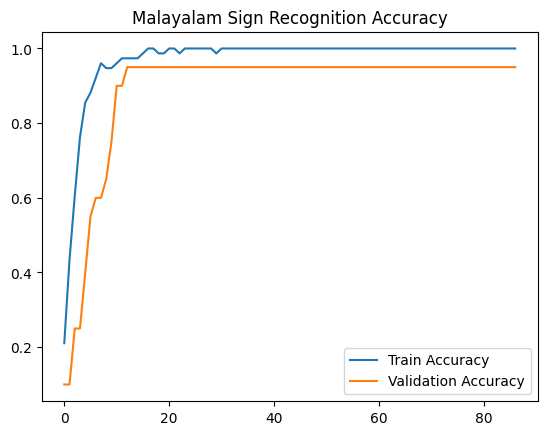

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Malayalam Sign Recognition Accuracy')
plt.legend()
plt.show()

In [ ]:
from gtts import gTTS
import IPython.display as ipd

def speak_sign(prediction_index):
    # 1. Get the Malayalam label
    malayalam_text = actions[prediction_index]
    print(f"🔊 Speaking: {malayalam_text}")

    # 2. Synthesize Speech
    tts = gTTS(text=malayalam_text, lang='ml')
    tts.save("output.mp3")

    # 3. Play in Colab
    return ipd.Audio("output.mp3", autoplay=True)

# Example usage after training:
res = sas_model.predict(X_test)
speak_sign(np.argmax(res[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
🔊 Speaking: ഈ


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 3348 (\N{MALAYALAM LETTER AU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Malayalam natively.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 3338 (\N{MALAYALAM LETTER UU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 3333 (\N{MALAYALAM LETTER A}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 3330 (\N{MALAYALAM SIGN ANUSVARA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 3344 (\N{MALAYALAM LETTER AI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/pytho

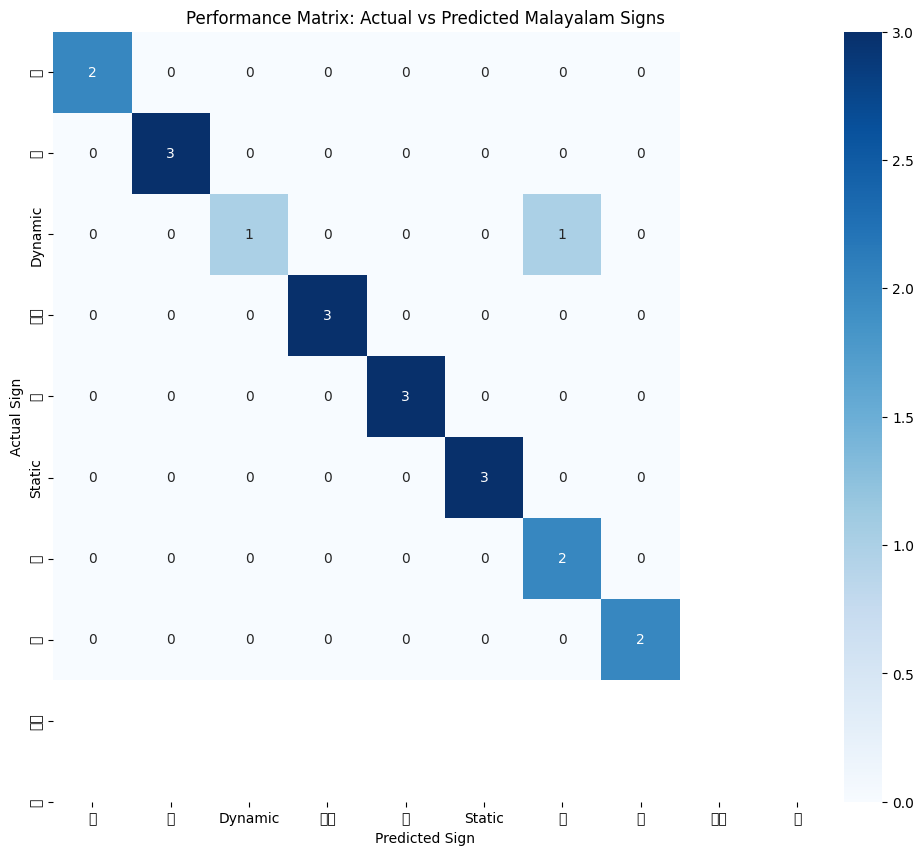

In [ ]:
 from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get predictions for the test set
yhat = sas_model.predict(X_test)

# 2. Convert from one-hot encoding back to categorical integers
ytrue = np.argmax(y_test, axis=1)
yhat = np.argmax(yhat, axis=1)

# 3. Create the Confusion Matrix
cm = confusion_matrix(ytrue, yhat)

# 4. Visualize using Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=actions, yticklabels=actions)
plt.title('Performance Matrix: Actual vs Predicted Malayalam Signs')
plt.ylabel('Actual Sign')
plt.xlabel('Predicted Sign')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Use the model to predict the test set
yhat = sas_model.predict(X_test)
ytrue = np.argmax(y_test, axis=1)
yhat = np.argmax(yhat, axis=1)

# Generate the report
print(classification_report(ytrue, yhat, target_names=actions, labels=range(len(actions))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
              precision    recall  f1-score   support

           ഔ       1.00      1.00      1.00         2
           ഊ       1.00      1.00      1.00         3
     Dynamic       1.00      0.50      0.67         2
          അം       1.00      1.00      1.00         3
           ഐ       1.00      1.00      1.00         3
      Static       1.00      1.00      1.00         3
           ഓ       0.67      1.00      0.80         2
           ഈ       1.00      1.00      1.00         2
          അഃ       0.00      0.00      0.00         0
           ഏ       0.00      0.00      0.00         0

    accuracy                           0.95        20
   macro avg       0.77      0.75      0.75        20
weighted avg       0.97      0.95      0.95        20



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

In [ ]:
def predict_and_speak_malayalam(sequence):
    # sequence shape: (1, 30, 1662)
    res = sas_model.predict(sequence)
    predicted_idx = np.argmax(res)
    confidence = res[0][predicted_idx]

    label = actions[predicted_idx]

    print(f"Prediction: {label} ({confidence*100:.2f}%)")

    # Trigger the audio
    if confidence > 0.8: # Only speak if the model is sure
        speak_sign(predicted_idx)
    else:
        print("Confidence too low to synthesize speech.")

# Test it with the first sample from your test set
predict_and_speak_malayalam(np.expand_dims(X_test[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: ഈ (98.75%)
🔊 Speaking: ഈ


In [ ]:
import json

# Save your action labels to a JSON file
with open('actions.json', 'w', encoding='utf-8') as f:
    json.dump(actions.tolist(), f, ensure_ascii=False)

print("✅ actions.json saved. You'll need this for your final web app or mobile deployment.")

✅ actions.json saved. You'll need this for your final web app or mobile deployment.


In [ ]:
# Use this to 'speak' the result
def predict_and_audio(test_sequence):
    prediction = sas_model.predict(np.expand_dims(test_sequence, axis=0))
    char_idx = np.argmax(prediction)
    malayalam_char = actions[char_idx]

    print(f"Detected: {malayalam_char}")
    # Call your gTTS function here
    # speak_sign(char_idx)

# Example test
predict_and_audio(X_test[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Detected: ഈ


In [ ]:
import numpy as np
from gtts import gTTS
import IPython.display as ipd
import tensorflow as tf

def translate_sign_to_audio(input_data):
    """
    input_data: A single sequence of (30, 1662)
    """
    # 1. Predict using the model
    prediction = sas_model.predict(np.expand_dims(input_data, axis=0), verbose=0)
    char_idx = np.argmax(prediction)
    confidence = prediction[0][char_idx]

    # 2. Map index to Malayalam Label
    malayalam_text = actions[char_idx]

    # 3. Text-to-Speech (Synthesis)
    print(f"✨ Result: {malayalam_text} | Confidence: {confidence*100:.2f}%")

    if confidence > 0.7:
        tts = gTTS(text=malayalam_text, lang='ml')
        tts.save("result.mp3")
        return ipd.Audio("result.mp3", autoplay=True)
    else:
        print("⚠️ Confidence too low for audio output.")
        return None

# Test it with a sample from your test set
translate_sign_to_audio(X_test[0])

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(sas_model)
# Optimize for size/speed
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Apply the suggested fixes from the error message
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS # Enable select TensorFlow ops
]
converter._experimental_lower_tensor_list_ops = False # Disable problematic experimental flag

tflite_model = converter.convert()

# Save it
with open('malayalam_sas_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("✅ Model converted to TFLite for mobile/edge deployment!")

✨ Result: ഈ | Confidence: 98.75%
Saved artifact at '/tmp/tmp3262ug_r'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 1662), dtype=tf.float32, name='keras_tensor_9')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  137233507318096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137233507318480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137233507317520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137233507316752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137233507318288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137233507318864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137233507317328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137233507317136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137233507319440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137233507319632: TensorSpec(shape=(), dtype=tf.resou

In [ ]:
import os
import json
import zipfile
from google.colab import files

# 1. Create a Metadata file for your actions (labels)
with open('actions.json', 'w', encoding='utf-8') as f:
    json.dump(actions.tolist(), f, ensure_ascii=False)

# 2. Define the files you want to keep
files_to_zip = [
    'malayalam_sas_model.tflite',
    'actions.json',
    'best_sas_model.keras' # Keeping the heavy version just in case
]

# 3. Create the ZIP archive
zip_name = 'Malayalam_SAS_Project_Final.zip'
with zipfile.ZipFile(zip_name, 'w') as zipf:
    for file in files_to_zip:
        if os.path.exists(file):
            zipf.write(file)
            print(f"Added {file} to ZIP.")
        else:
            print(f"⚠️ Warning: {file} not found. Skipping.")

# 4. Trigger the browser download
print(f"🚀 Downloading {zip_name}...")
files.download(zip_name)

Added malayalam_sas_model.tflite to ZIP.
Added actions.json to ZIP.
⚠️ Warning: best_sas_model.keras not found. Skipping.
🚀 Downloading Malayalam_SAS_Project_Final.zip...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="malayalam_sas_model.tflite")
interpreter.allocate_tensors()

# Get details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("--- TFLite Model Entry Point ---")
print(f"Input Shape: {input_details[0]['shape']}")
print(f"Input Type: {input_details[0]['dtype']}")
print(f"Output Shape: {output_details[0]['shape']}")
print("--------------------------------")

--- TFLite Model Entry Point ---
Input Shape: [   1   30 1662]
Input Type: <class 'numpy.float32'>
Output Shape: [1 8]
--------------------------------


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:
import tensorflow as tf
import numpy as np
from gtts import gTTS
import IPython.display as ipd

# 1. Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="malayalam_sas_model.tflite")
interpreter.allocate_tensors()

# 2. Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def predict_and_speak_lite(sequence_data):
    # Ensure input is float32 and has the right batch dimension
    input_data = np.expand_dims(sequence_data, axis=0).astype(np.float32)

    # 3. Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # 4. Run inference
    interpreter.invoke()

    # 5. Get the result
    prediction = interpreter.get_tensor(output_details[0]['index'])
    char_idx = np.argmax(prediction)
    label = actions[char_idx]

    print(f"✅ TFLite Prediction: {label} (Confidence: {np.max(prediction)*100:.2f}%)")

    # 6. Malayalam Synthesis
    tts = gTTS(text=label, lang='ml')
    tts.save("final_output.mp3")
    return ipd.Audio("final_output.mp3", autoplay=True)

# Test it with one sequence from your test set
predict_and_speak_lite(X_test[0])

✅ TFLite Prediction: ഈ (Confidence: 98.75%)


In [ ]:
import cv2
import numpy as np
from collections import deque

class RealTimeSignRecognizer:
    def __init__(self, model_path, actions, sequence_length=30):
        self.model = tf.keras.models.load_model(model_path)
        self.actions = actions
        self.sequence_length = sequence_length

        # Initialize MediaPipe
        self.holistic_model = Holistic(
            min_detection_confidence=0.7,  # Increased for stability
            min_tracking_confidence=0.7
        )

        # Use deque for efficient frame management
        self.sequence = deque(maxlen=sequence_length)

        # Prediction smoothing
        self.prediction_history = deque(maxlen=5)  # Last 5 predictions
        self.current_prediction = None
        self.confidence_threshold = 0.8

        # FPS calculation
        self.prev_time = 0

    def extract_keypoints(self, results):
        """Same as before but optimized"""
        pose = np.array([[res.x, res.y, res.z, res.visibility]
                        for res in results.pose_landmarks.landmark]).flatten() \
               if results.pose_landmarks else np.zeros(33*4)

        face = np.array([[res.x, res.y, res.z]
                        for res in results.face_landmarks.landmark]).flatten() \
               if results.face_landmarks else np.zeros(468*3)

        lh = np.array([[res.x, res.y, res.z]
                      for res in results.left_hand_landmarks.landmark]).flatten() \
             if results.left_hand_landmarks else np.zeros(21*3)

        rh = np.array([[res.x, res.y, res.z]
                      for res in results.right_hand_landmarks.landmark]).flatten() \
             if results.right_hand_landmarks else np.zeros(21*3)

        return np.concatenate([pose, face, lh, rh])

    def smooth_prediction(self, prediction):
        """Smooth predictions using voting"""
        self.prediction_history.append(prediction)

        if len(self.prediction_history) < 3:
            return None

        # Majority voting
        from collections import Counter
        counts = Counter(self.prediction_history)
        most_common = counts.most_common(1)[0]

        # Only return if appears at least 3 times
        if most_common[1] >= 3:
            return most_common[0]
        return None

    def process_frame(self, frame):
        """Process single frame and update sequence"""
        # Convert BGR to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # MediaPipe detection
        results = self.holistic_model.process(image)

        # Extract keypoints
        keypoints = self.extract_keypoints(results)

        # Add to sequence
        self.sequence.append(keypoints)

        return results, image

    def predict(self):
        """Make prediction when sequence is full"""
        if len(self.sequence) < self.sequence_length:
            return None, 0.0

        # Prepare input
        input_data = np.array(list(self.sequence)).reshape(1, self.sequence_length, 1662)

        # Predict
        prediction = self.model.predict(input_data, verbose=0)[0]
        predicted_idx = np.argmax(prediction)
        confidence = prediction[predicted_idx]

        if confidence > self.confidence_threshold:
            smoothed = self.smooth_prediction(predicted_idx)
            if smoothed is not None:
                return self.actions[smoothed], confidence

        return None, confidence

    def draw_landmarks(self, image, results):
        """Draw landmarks on image"""
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw pose
        if results.pose_landmarks:
            mp.solutions.drawing_utils.draw_landmarks(
                image, results.pose_landmarks,
                mp.solutions.holistic.POSE_CONNECTIONS
            )

        # Draw hands
        if results.left_hand_landmarks:
            mp.solutions.drawing_utils.draw_landmarks(
                image, results.left_hand_landmarks,
                mp.solutions.holistic.HAND_CONNECTIONS
            )

        if results.right_hand_landmarks:
            mp.solutions.drawing_utils.draw_landmarks(
                image, results.right_hand_landmarks,
                mp.solutions.holistic.HAND_CONNECTIONS
            )

        return image

    def calculate_fps(self):
        """Calculate FPS"""
        import time
        current_time = time.time()
        fps = 1 / (current_time - self.prev_time) if self.prev_time else 0
        self.prev_time = current_time
        return fps

    def run(self):
        """Main real-time loop"""
        cap = cv2.VideoCapture(0)  # 0 for webcam

        # Set camera properties for better performance
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
        cap.set(cv2.CAP_PROP_FPS, 30)

        print("🎥 Starting real-time sign language recognition...")
        print("Press 'q' to quit")

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Process frame
            results, processed_image = self.process_frame(frame)

            # Draw landmarks
            output_image = self.draw_landmarks(processed_image.copy(), results)

            # Make prediction
            prediction, confidence = self.predict()

            # Calculate FPS
            fps = self.calculate_fps()

            # Display info on frame
            cv2.putText(output_image, f'FPS: {int(fps)}', (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            cv2.putText(output_image, f'Frames: {len(self.sequence)}/{self.sequence_length}',
                       (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            if prediction:
                # Display prediction
                cv2.putText(output_image, f'Sign: {prediction}', (10, 110),
                           cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)

                cv2.putText(output_image, f'Confidence: {confidence*100:.1f}%',
                           (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            else:
                cv2.putText(output_image, 'Detecting...', (10, 110),
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 165, 255), 2)

            # Show frame
            cv2.imshow('Malayalam Sign Language Recognition', output_image)

            # Quit on 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()
        self.holistic_model.close()

In [ ]:
!pip install playsound
import threading
import queue
from gtts import gTTS
from playsound import playsound  # pip install playsound
import os

class AsyncAudioPlayer:
    def __init__(self):
        self.audio_queue = queue.Queue()
        self.last_spoken = None
        self.speaking = False

        # Start worker thread
        self.worker_thread = threading.Thread(target=self._audio_worker, daemon=True)
        self.worker_thread.start()

    def _audio_worker(self):
        """Background thread for audio playback"""
        while True:
            text = self.audio_queue.get()
            if text is None:  # Stop signal
                break

            try:
                self.speaking = True
                # Generate audio
                tts = gTTS(text=text, lang='ml', slow=False)
                temp_file = f"temp_{hash(text)}.mp3"
                tts.save(temp_file)

                # Play audio
                playsound(temp_file)

                # Cleanup
                os.remove(temp_file)
                self.speaking = False

            except Exception as e:
                print(f"Audio error: {e}")
                self.speaking = False

            self.audio_queue.task_done()

    def speak(self, text):
        """Add text to speech queue"""
        # Avoid repeating same word
        if text != self.last_spoken and not self.speaking:
            self.audio_queue.put(text)
            self.last_spoken = text

    def stop(self):
        """Stop the audio worker"""
        self.audio_queue.put(None)

  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7020 sha256=7b819ce9fa6fbcefec36cf41cafc57a027af93075e6501d923f86e28c26d86ef
  Stored in directory: /root/.cache/pip/wheels/cf/42/ff/7c587bae55eec67b909ca316b250d9b4daedbf272a3cbeb907
Successfully built playsound


In [ ]:
def create_lightweight_model(num_classes):
    """Faster model for real-time inference"""
    Model = Sequential([
        Input(shape=(30, 1662)),
        # Lighter architecture
        LSTM(32, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        LSTM(64, return_sequences=False, activation='tanh'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    Model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return Model

# Convert to TFLite with optimizations
converter = tf.lite.TFLiteConverter.from_keras_model(Model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]  # Use FP16 for speed
tflite_model = converter.convert()

NameError: name 'Model' is not defined